# Prepare some things

## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

import numpy as np

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
# Load the model class and some custom functions
from models import get_autoencoder_model, get_dec_model, compute_p, compute_delta
from evaluate_model import evaluate_clustering_performance
from draw_embeddings import draw_embeddings, draw_clusters_assignments, compare_reconstructed_images_MNIST

## Load and prepare the MNIST data set

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

# Pretrain the model

## Construct and pretrain the autoencoder

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)

EPOCHS = 20
BATCH_SIZE = 128

model_ae = get_autoencoder_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)

# model_ae.encoder.summary()
# model_ae.decoder.summary()

In [5]:
model_ae.compile(optimizer=keras.optimizers.Adam(),
                 loss=tf.keras.losses.BinaryCrossentropy(reduction='sum'))

model_ae.fit(x_train, x_train,
             epochs=EPOCHS,
             batch_size=128,
             verbose=2,
            )

model_ae.save_weights("model_weights/dec/pretrained/ae")

model_ae.load_weights("model_weights/dec/pretrained/ae")

Epoch 1/20
469/469 - 4s - loss: 24.8385 - 4s/epoch - 9ms/step
Epoch 2/20
469/469 - 2s - loss: 18.9761 - 2s/epoch - 5ms/step
Epoch 3/20
469/469 - 3s - loss: 18.1328 - 3s/epoch - 6ms/step
Epoch 4/20
469/469 - 2s - loss: 17.6464 - 2s/epoch - 5ms/step
Epoch 5/20
469/469 - 3s - loss: 17.2660 - 3s/epoch - 5ms/step
Epoch 6/20
469/469 - 2s - loss: 16.9580 - 2s/epoch - 5ms/step
Epoch 7/20
469/469 - 2s - loss: 16.7140 - 2s/epoch - 5ms/step
Epoch 8/20
469/469 - 2s - loss: 16.4773 - 2s/epoch - 5ms/step
Epoch 9/20
469/469 - 2s - loss: 16.2931 - 2s/epoch - 5ms/step
Epoch 10/20
469/469 - 3s - loss: 16.1056 - 3s/epoch - 5ms/step
Epoch 11/20
469/469 - 3s - loss: 15.9751 - 3s/epoch - 5ms/step
Epoch 12/20
469/469 - 3s - loss: 15.8616 - 3s/epoch - 6ms/step
Epoch 13/20
469/469 - 3s - loss: 15.7706 - 3s/epoch - 5ms/step
Epoch 14/20
469/469 - 3s - loss: 15.6633 - 3s/epoch - 6ms/step
Epoch 15/20
469/469 - 2s - loss: 15.5783 - 2s/epoch - 5ms/step
Epoch 16/20
469/469 - 2s - loss: 15.4936 - 2s/epoch - 5ms/step
E

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


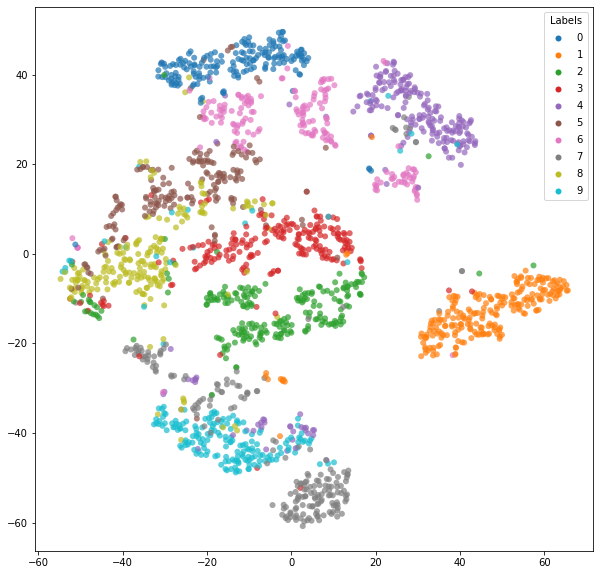

In [6]:
if LATENT_DIM == 2:
    z_train = model_ae.encode(x_train)
    draw_embeddings(z_train, y_train)
else:
    z_test = model_ae.encode(x_test)
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_embeddings(z_tsne, y_test[0:2000], alpha=0.7)

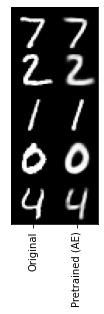

In [7]:
compare_orig_vs_pretrained = compare_reconstructed_images_MNIST(x_test, model_ae.encoder, model_ae.decoder, ("Original", "Pretrained (AE)"))

# Fine-tune the model (K-Means)

## Construct the full VaDE model

Load the pretrained weights for the encoder and decoder modules:

In [8]:
model_ae.load_weights("model_weights/dec/pretrained/ae")

Construct the VaDE model:

In [9]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)

## Initialize the parameters

Initialize the model parameters from a K-means:

In [10]:
z_train = model_dec.encode(x_train)

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
kmeans.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(kmeans.cluster_centers_))

Initialize `p`, the auxiliary distribution to compute the clustering loss, and `c_last`, the last cluster assignments to compute the number of points that changed clusters.

In [11]:
p = compute_p(to_categorical(kmeans.labels_))
c_last = kmeans.labels_

Evaluate the clustering performance before fine-tunning the model:

In [12]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_dec.encode(x_train)
    draw_embeddings(z_train, y_train, centroids=kmeans.cluster_centers_)

Acc: 0.5086
ARI: 0.2606
AMI: 0.4625
Sil: 0.2602


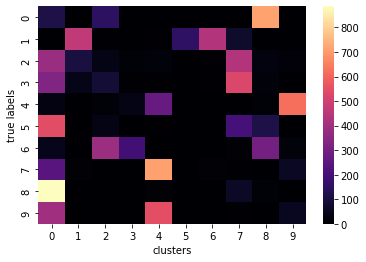

In [13]:
evaluate_clustering_performance(model_dec.classify, x_test, y_test, True, model_dec.encode)

## Train the model

Train the model:

In [14]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(x_train)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [15]:
model_dec.compile(optimizer=keras.optimizers.Adam())

model_dec.fit(x_train, p,
              epochs=EPOCHS,
              batch_size=128,
              callbacks = callback,
              verbose=2,
             )

model_dec.save_weights("model_weights/dec/finetuned/dec_kmeans")

model_dec.load_weights("model_weights/dec/finetuned/dec_kmeans")

Epoch 1/100
469/469 - 3s - loss: 517.8899 - 3s/epoch - 7ms/step
Epoch 2/100
469/469 - 3s - loss: 372.6153 - 3s/epoch - 5ms/step
Epoch 3/100
469/469 - 3s - loss: 303.3754 - 3s/epoch - 6ms/step
Epoch 4/100
469/469 - 3s - loss: 250.8425 - 3s/epoch - 6ms/step
Epoch 5/100
469/469 - 3s - loss: 215.1192 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - loss: 187.0147 - 3s/epoch - 6ms/step
Epoch 7/100
469/469 - 3s - loss: 168.3027 - 3s/epoch - 5ms/step
Epoch 8/100
469/469 - 2s - loss: 149.4422 - 2s/epoch - 5ms/step
Epoch 9/100
469/469 - 3s - loss: 137.3643 - 3s/epoch - 5ms/step
Epoch 10/100
Delta: 0.029
469/469 - 3s - loss: 129.3698 - 3s/epoch - 7ms/step
Epoch 11/100
469/469 - 3s - loss: 116.6473 - 3s/epoch - 6ms/step
Epoch 12/100
469/469 - 3s - loss: 107.3343 - 3s/epoch - 6ms/step
Epoch 13/100
469/469 - 3s - loss: 103.2671 - 3s/epoch - 6ms/step
Epoch 14/100
469/469 - 3s - loss: 96.2671 - 3s/epoch - 5ms/step
Epoch 15/100
469/469 - 2s - loss: 94.4290 - 2s/epoch - 5ms/step
Epoch 16/100
469/469 - 

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


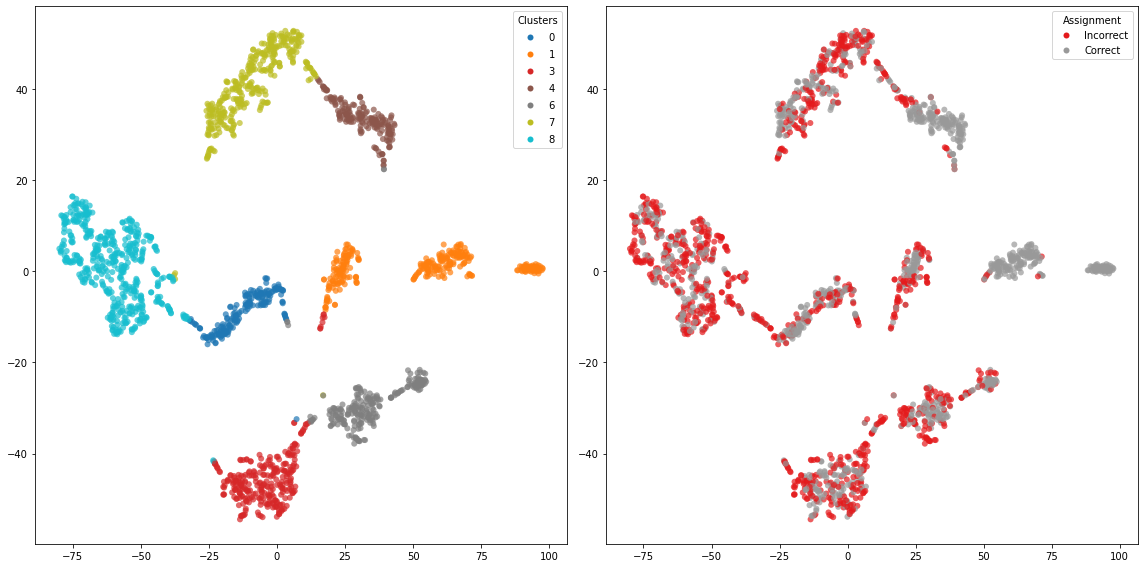

In [16]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

## Evaluate the model

Acc: 0.5169
ARI: 0.2715
AMI: 0.4741
Sil: 0.9105


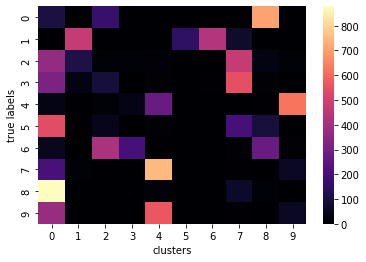

In [17]:
evaluate_clustering_performance(model_dec.classify, x_test, y_test, True, model_dec.encode)

# Fine-tune the model (GMM)

## Construct the model and load the pretrained weights

Load the pretrained weights for the encoder and decoder modules:

In [18]:
model_ae.load_weights("model_weights/dec/pretrained/ae")

In [19]:
N_CLUSTERS = 10
CLUSTERING_LOSS_WEIGHT = 0.1

EPOCHS = 100
BATCH_SIZE = 128
SCHEDULE = 10
DELTA_THRESHOLD = 0.01

model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)

## Initialize the parameters

In [20]:
z_train = model_dec.encode(x_train)

gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)
gmm.fit(z_train)

for weight in model_dec.trainable_weights:
    if weight.name == "centroids:0":
        weight.assign(K.constant(gmm.means_))

In [21]:
p = compute_p(to_categorical(gmm.predict(z_train)))
c_last = gmm.predict(z_train)

Evaluate the clustering performance before fine-tunning the model:

In [22]:
# Show the embeddings and the cluster centroids on the latent space
if LATENT_DIM == 2:
    z_train = model_dec.encode_only_mu(x_train)
    draw_embeddings(z_train, y_train, centroids=gmm.means_)

Acc: 0.4993
ARI: 0.2943
AMI: 0.4586
Sil: 0.2008


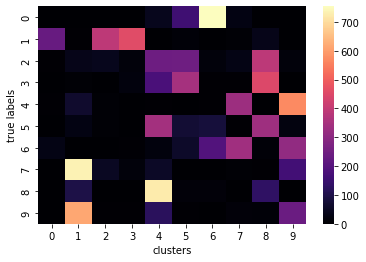

In [23]:
evaluate_clustering_performance(model_dec.classify, x_test, y_test, True, model_dec.encode)

## Train the model

In [24]:
model_dec.compile(optimizer=keras.optimizers.Adam())

model_dec.fit(x_train, p,
              epochs=EPOCHS,
              batch_size=128,
              callbacks = callback,
              verbose=2,
             )

model_dec.save_weights("model_weights/dec/finetuned/dec_gmm")

model_dec.load_weights("model_weights/dec/finetuned/dec_gmm")

Epoch 1/100
469/469 - 3s - loss: 595.1039 - 3s/epoch - 6ms/step
Epoch 2/100
469/469 - 2s - loss: 442.5471 - 2s/epoch - 4ms/step
Epoch 3/100
469/469 - 2s - loss: 363.1324 - 2s/epoch - 5ms/step
Epoch 4/100
469/469 - 2s - loss: 308.9236 - 2s/epoch - 4ms/step
Epoch 5/100
469/469 - 2s - loss: 268.2519 - 2s/epoch - 4ms/step
Epoch 6/100
469/469 - 2s - loss: 236.0453 - 2s/epoch - 4ms/step
Epoch 7/100
469/469 - 2s - loss: 214.8723 - 2s/epoch - 4ms/step
Epoch 8/100
469/469 - 2s - loss: 194.7903 - 2s/epoch - 4ms/step
Epoch 9/100
469/469 - 2s - loss: 179.1993 - 2s/epoch - 4ms/step
Epoch 10/100
Delta: 0.042
469/469 - 2s - loss: 167.0083 - 2s/epoch - 5ms/step
Epoch 11/100
469/469 - 2s - loss: 156.2294 - 2s/epoch - 4ms/step
Epoch 12/100
469/469 - 2s - loss: 143.2923 - 2s/epoch - 5ms/step
Epoch 13/100
469/469 - 2s - loss: 135.9906 - 2s/epoch - 4ms/step
Epoch 14/100
469/469 - 2s - loss: 130.6305 - 2s/epoch - 5ms/step
Epoch 15/100
469/469 - 2s - loss: 124.6853 - 2s/epoch - 4ms/step
Epoch 16/100
469/469 

## Show the resulting embeddings

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


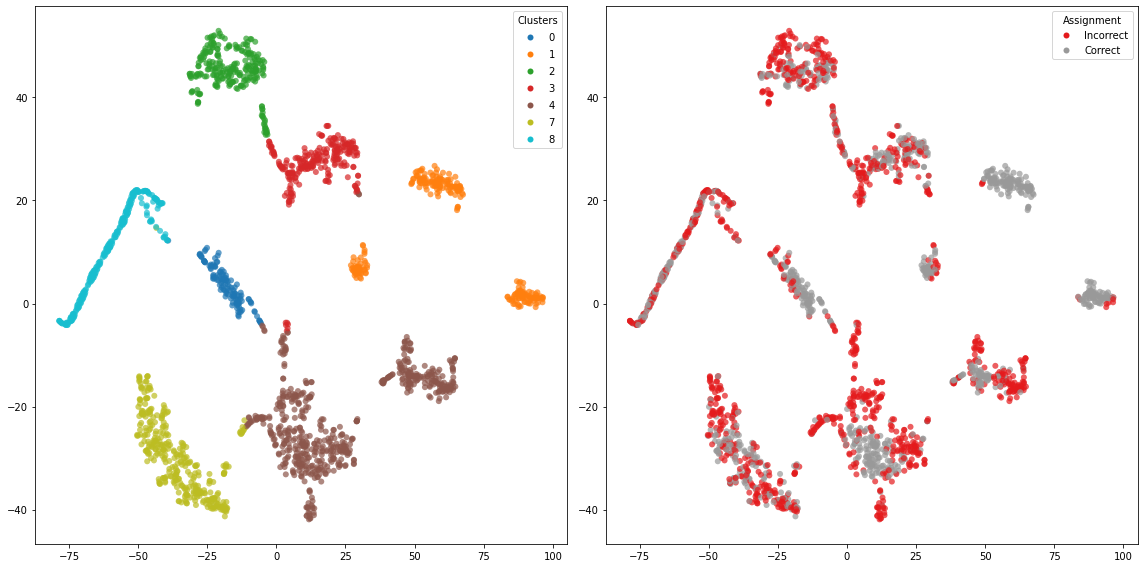

In [25]:
z_test = model_dec.encode(x_test)
c_test = model_dec.classify(x_test)

if LATENT_DIM == 2:
    draw_clusters_assignments(z_test, y_test, c_test)
else:
    tsne = TSNE(n_components=2, init='pca')
    z_tsne = tsne.fit_transform(z_test[0:2000])
    draw_clusters_assignments(z_tsne, y_test[0:2000], c_test[0:2000], alpha=0.7)

## Evaluate the model

Acc: 0.4963
ARI: 0.2750
AMI: 0.4442
Sil: 0.8868


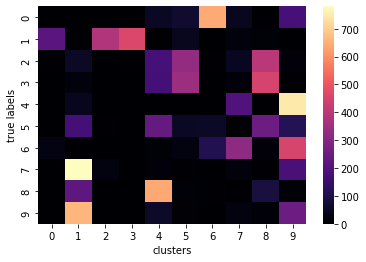

In [26]:
evaluate_clustering_performance(model_dec.classify, x_test, y_test, True, model_dec.encode)